# 캘리포니아 주택 가격 예측 모델 만들기

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

## 1. 데이터 가져오기

In [3]:
df = pd.read_csv('./datasets/housing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 2. 데이터 훑어보기

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**수치형 특성 히스토그램**

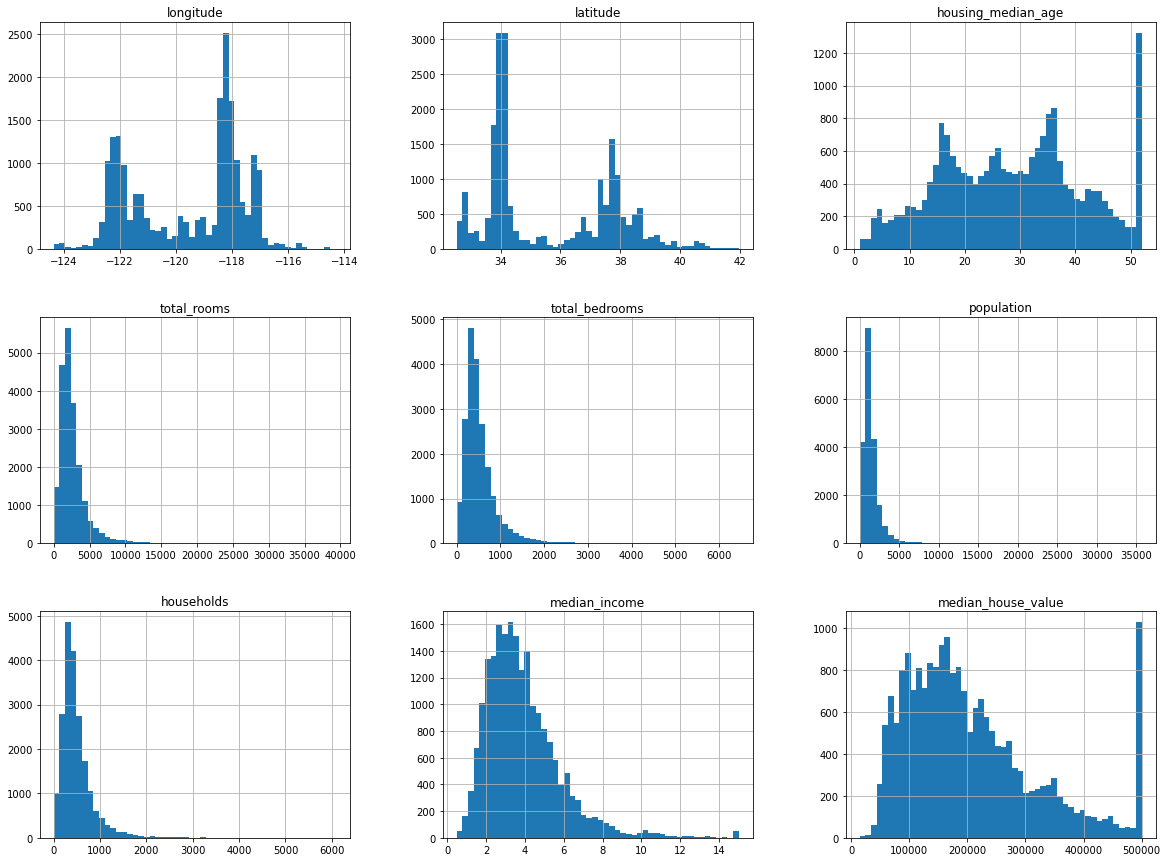

In [15]:
h = df.hist(bins=50, figsize=(20, 15))

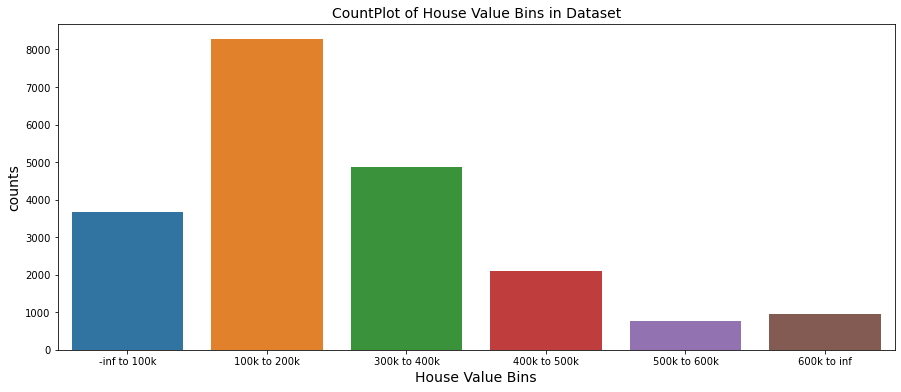

In [10]:
house_value_bins = pd.cut(x=df["median_house_value"],
                          bins=(-np.inf, 100000, 200000, 300000, 400000, 500000, np.inf),
                                labels=('-inf to 100k', '100k to 200k', '300k to 400k', '400k to 500k', '500k to 600k', '600k to inf') )
plt.figure(figsize=(15,6)) 
sns.countplot(x=house_value_bins) 
plt.title('CountPlot of House Value Bins in Dataset', fontsize=14, c='k') 
plt.xlabel('House Value Bins', fontsize=14, c='k') 
plt.ylabel('counts', fontsize=14,c='k') 
plt.show() 

## 3. 데이터 세트 분리
- 훈련 데이터/ 테스트 데이터

 - csv하나로 제공되는 경우 train과 test를 분리 해야함
 - 가장 간편한거는 train_test_split 함수를 이용해서 train, test = train_test_split(df, test_size=-0.2)
 - 여기서 사용할 방법은 계층적 샘플링()

**계층적 샘플링**

In [18]:
bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf]
labels = [1,2,3,4,5]
df['income_cat'] = pd.cut(df['median_income'], bins=bins, labels=labels)

In [28]:
df.drop(['imcome_cat'], axis=1, inplace=True)

In [29]:
df['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [30]:
df['income_cat'].value_counts() / len(df) # 상대도수 (%)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [31]:
from sklearn.model_selection import train_test_split

 - income 카테고리가 중요하므로 무작위추출이 아니라 비율이 반영되도록 stratify 추가 (계층 반영 목적)

In [33]:
strat_train_set, strat_test_set = train_test_split(df, stratify=df['income_cat'], test_size=0.2, random_state=42)

In [40]:
strat_train_set['income_cat'].value_counts()

3    5789
2    5265
4    2911
5    1890
1     657
Name: income_cat, dtype: int64

In [37]:
# 비율이 반영 됐는지 확인
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [39]:
strat_test_set['income_cat'].value_counts()

3    1447
2    1316
4     728
5     472
1     165
Name: income_cat, dtype: int64

In [38]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

**데이터 되돌리기**

In [43]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

In [44]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

## 4. 데이터 탐색

**탐색적 데이터분석**
- 어떤 특성을 선택할지, 제거할지, 조합을 통해서 더 좋은 특성을 만들 수 있는지를 분석
- 시각화(데이터의 경향성, 왜곡, 특잇값, 통계적정보)
- 상관관계, 누락데이터(결측치)를 종합적으로 분석
- 탐색적 데이터 분석의 결과로 모델링 방향을 결정할 수 있음

In [ ]:
# 훈련셋 만을 대상으로 탐색과 시각화 적용, copy를 통해 메모리에 새롭게 적재
# start_test_set은 마지막에 사용 예정 (최종 예측 단계)
housing = start_train_set.copy()

### 4.1 지리적 데이터 시각화

 - 위도, 경도 활용

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

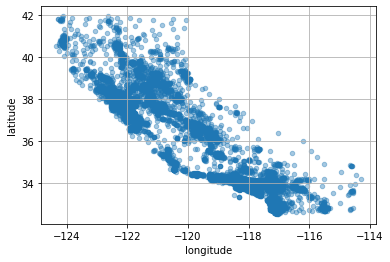

In [49]:
# longitude = 경도(동서), latitude = 위도(남북)
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, grid=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

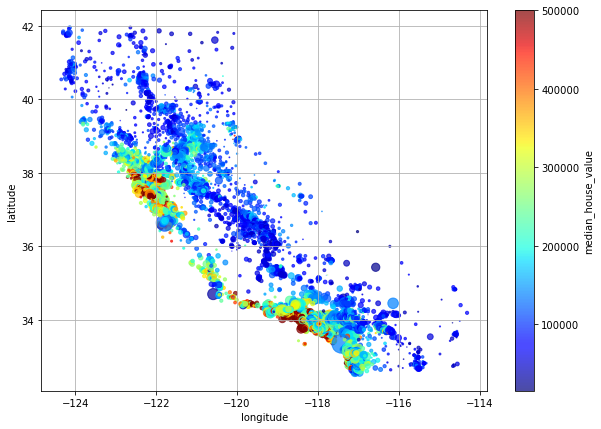

In [56]:
# s=사이즈, s에 인구수 넣고 표 산출시 동그라미 추가
# c=컬러 정보를 통해서 주택 가격 표시
# s=마커의 사이즈를 통해서 인구수 표시
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.7, grid=True, c='median_house_value', 
        cmap='jet', colorbar=True, figsize=(10,7), s=df['population']/100,sharex=False)

**지리적 데이터 분석 결과**
: 해안가 이면서 밀집지역일수록 집값이 높고 인구수가 많음

### 4.2 상관관계 조사

- 상관계수

In [57]:
df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [58]:
# 모든 수치형 상관계수 확인
corr_matrix = df.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [61]:
# target (중간 주택 가격)과 다른 특성간의 상관관계 확인
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

- 산점도 (수치 뿐만 아니라 경향성도 같이 볼 수 있다)

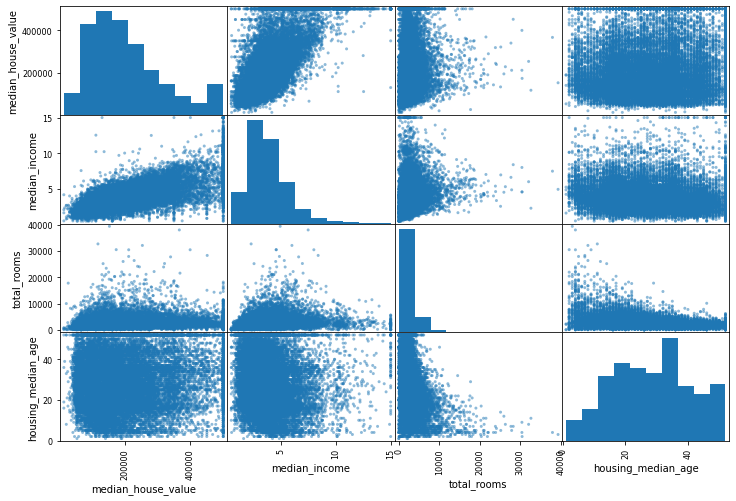

In [65]:
# 산점도를 행렬형식으로 보여주는 scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

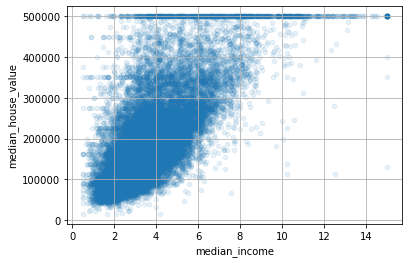

In [66]:
# 중간 주택 가격과 중간소득의 산점도
df.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)

In [68]:
df['rooms_per_household'] = df['total_rooms'] / df['households'] # 가구당 room 개수
df['bedrooms_per_rooms'] = df['total_bedrooms'] / df['total_rooms'] # room 중에 bedroom 개수
df['population_per_household'] = df['population'] / df['households'] # 가구당 인구수

In [70]:
corr_matrix = df.corr()
corr_matrix['median_house_value']

longitude                  -0.045967
latitude                   -0.144160
housing_median_age          0.105623
total_rooms                 0.134153
total_bedrooms              0.049686
population                 -0.024650
households                  0.065843
median_income               0.688075
median_house_value          1.000000
rooms_per_household         0.151948
bedrooms_per_rooms         -0.255880
population_per_household   -0.023737
Name: median_house_value, dtype: float64

### 4.3 특성 조합을 실험

## 5. 데이터 전처리

In [ ]:
# strat_train_set 시각과, 전처리
# strat_test_set 최종 예측

In [71]:
# 특성과 레이블 분리
housing = strat_train_set.drop('median_house_value', axis=1) # 특성 (X 데이터)
housing_label = strat_train_set['median_house_value'].copy() # 레이블 (y 데이터)

### 5.1 데이터 전처리(1) - 결손값 처리
 - 1: 해당 구역 제거
 - 2: 전체 특성 삭제
 - 3: 다른 값으로 대체(0, 평균값, 중간값 등)

**scikit-learn의 전처리기를 이용하여 다른값으로 대체**


In [ ]:
# sklearn의 전처리기들
# preprocessing -> PolynomialFeatures
# preprocessing -> StandardScaler
# impute -> SimpleImputer
# OneHotEncoder
# LabelEncoder, OrdinalEncoder
# MinMaxScaler
# 함수를 이용한 전처리기
# custom 전처리기

In [75]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [76]:
housing_num = housing.drop('ocean_proximity', axis=1) # 수치형 데이터
# 아래부터는 새로운 데이터 추출 방식
# housing_num = housing.select_dtypes(include=[np.number])
# housing_obj = ....[np.object]

In [72]:
# SimpleImputer 을 사용해서 결측값을 대체
from sklearn.impute import SimpleImputer

In [81]:
imputer = SimpleImputer(strategy='median') # 대체값 생성해서 imputer 라는 변수에 대입
# 변환 할 준비, 아마도 중앙값 median을 구하는 것
imputer.fit(housing_num)


SimpleImputer(strategy='median')

In [82]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [83]:
# 모든 컬럼에 대한 중앙값
housing_num.median() 

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [86]:
X = imputer.transform(housing_num)

In [88]:
housing_num_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_num_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### 5.2 데이터 전처리(2) - 데이터 인코딩
- 데이터 인코딩을 하는 이유는 머신러닝에서 수치값만 기대하기 때문

In [89]:
housing_cat = housing[['ocean_proximity']] # 2차원의 데이터 프레임으로 준비
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


#### (1) 레이블 인코딩

In [ ]:
# pandas
pd.factorize(housing['ocean_proximity']) # 알아서 숫자형으로 맵핑

In [93]:
# sklearn
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit_transform(housing_cat)

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [94]:
housing_cat[:5]

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


#### (2) 원핫 인코딩
 - 숫자의 크기가 모델 훈련과정에서 잘못된 영향을 줄 수 있으므로 원핫 인코딩

In [95]:
# pandas
pd.get_dummies(housing_cat)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0
...,...,...,...,...,...
15174,1,0,0,0,0
12661,0,1,0,0,0
19263,1,0,0,0,0
19140,1,0,0,0,0


In [97]:
# sklearn
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit_transform(housing_cat)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [98]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 5.3 데이터 전처리(3) - 특성 스케일링
- 표준화 (Z score Standardize) : 평균 0, 표준편차 1
- 정규화 (Min Max Scaling) : 0~1 사이로 정규화 (참고 : 특잇값에 영향을 받음)
- 로그 스케일링 : 데이터의 분포가 왜곡되어 있을때 주로 사용

In [99]:
arr = np.arange(9).reshape(3,3)

In [101]:
Z_arr = (arr - arr.mean()) / arr.std()


(<function ndarray.mean>, 1.0)

In [103]:
Z_arr.mean(), Z_arr.std()

(0.0, 1.0)

In [104]:
M_arr = (arr - arr.min()) / (arr.max() - arr.min())
M_arr.min(), M_arr.max()

(0.0, 1.0)

In [ ]:
#pandas 방식 스케일링
def minmax_normalize(arr):
    return (arr - arr.min() // (arr.max() - arr.min()))

def zscore_standize(arr):
    return (arr - arr.mean()) / arr.std()

In [105]:
# 표준화 Z score standardize 평균0 표준편차1
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std = std_scaler.fit_transform(housing_num)
housing_num_std.mean(0), housing_num_std.std(0)

(array([-5.24924634e-15,  2.81159678e-16,  8.77850764e-17, -1.54914841e-17,
                    nan,  6.45478503e-19, -1.05428155e-17,  1.14841384e-16]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

In [ ]:
# 정규화 man max scaling: 0~1 사이로 정규화

In [106]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
housing_num_mm = min_max_scaler.fit_transform(housing_num)
housing_num_mm.min(0), housing_num_mm.max(0)

(array([ 0.,  0.,  0.,  0., nan,  0.,  0.,  0.]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

<AxesSubplot:>

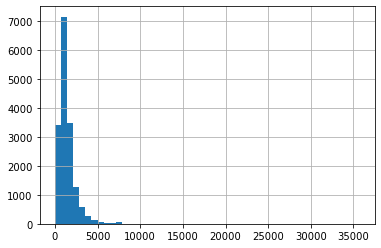

In [110]:
# 로그 스케일링 : 데이터의 분포가 왜곡되어 (편향되어) 있을 때 주로 사용
# 아래 히스토그램의 경우 왼쪽에 너무 몰려있다.
housing_num['population'].hist(bins=50)

In [112]:
from sklearn.preprocessing import FunctionTransformer
# 사용법
# a = FunctionTransformer(function) 함수를 인자로 받음
# a.fit_transform()

log_transformer = FunctionTransformer(np.log)
log_population = log_transformer.fit_transform(housing_num[['population']])

array([[<AxesSubplot:title={'center':'population'}>]], dtype=object)

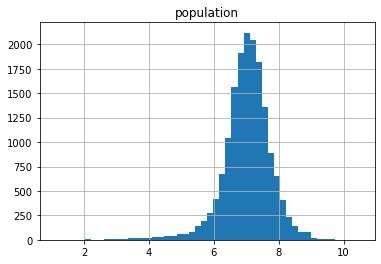

In [114]:
log_population.hist(bins=50) # 로그 변환하면 정규분포형으로 바뀜

### 5.4 데이터 전처리(4) - 변환 파이프라인

In [115]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

 - 수치형 데이터 : 스케일링, 누락된 값 처리
 - 범주형 데이터 : 원핫 인코딩

In [ ]:
# custom 변환기
# 수치형 데이터를 위한 파이프라인
# 누락된 데이터를 중앙값으로 대체 -> 표준화

In [121]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('std_scaler', StandardScaler())])
num_pipeline.fit_transform(housing_num)

# 완료 시 평균 0, 표준편차1 및 누락된값 없게 완료

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [125]:
num_attr = list(housing_num.columns.values)
cat_attr = ['ocean_proximity']

In [128]:
# 범주형 데이터를 위한 파이프라인
# 원핫 인코딩

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('onehot_encoder', OneHotEncoder()),('std_scaler', StandardScaler())])
# cat_pipeline.fit_transform(housing_cat)

# 범주형데이터는 누락값도 없었고, 0과1만 있으므로 스케일링이 필요하지도 않으므로 원핫 인코딩만 한다

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([('num_pipeline', num_pipeline, num_attr)
                                   ,('onehot_encorder', OneHotEncoder(), cat_attr)])

In [129]:
housing_prepared = full_pipeline.fit_transform(housing)

In [131]:
housing_prepared.shape

(16512, 13)

In [132]:
housing.shape

(16512, 9)

## 6. 모델 선택과 훈련
 - train용으로 훈련, 테스트용으로 검증 (X훈련 y정답)

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [154]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)

# 교차검증
# cross_val_socre(모델, 특성데이터, 정답데이터, 성능측정지표, 폴드수(몇개로나눌지))

In [155]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
lin_rmse = np.sqrt(-lin_scores).mean()
lin_rmse

69204.32275494766

In [156]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
tree_rmse = np.sqrt(-tree_scores).mean()
tree_rmse

69081.361562518

In [158]:
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
rf_rmse = np.sqrt(-rf_scores).mean()
rf_rmse

49432.12678796127

## 7. 모델 세부 튜닝

**그리드 탐색**

In [159]:
from sklearn.model_selection import GridSearchCV

In [160]:
rf_reg = RandomForestRegressor(random_state=42)

In [169]:
param_grid = {'n_estimators':[30, 50, 100, 200], 'max_features':[2, 4, 6, 8, 10]}

# GridSearchCV(rf_reg, 탐색할파라미터, 성능측정기준, 폴드수)
grid_search = GridSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # 3 * 4 * 5 = 60번 돌았다
# grid_search.fit(특성데이터, 정답데이터)
%time grid_search.fit(housing_prepared, housing_label)

CPU times: total: 10 s
Wall time: 1min 21s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [170]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 200}

In [166]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, random_state=42)

In [167]:
grid_search.cv_results_['mean_test_score']

array([-2.77450285e+09, -2.71143707e+09, -2.65510098e+09, -2.53719284e+09,
       -2.49811502e+09, -2.45845371e+09, -2.51782283e+09, -2.46566334e+09,
       -2.43701750e+09, -2.49411500e+09, -2.44882741e+09, -2.41677101e+09])

In [168]:
grid_search.cv_results_['params']

[{'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 50},
 {'max_features': 2, 'n_estimators': 100},
 {'max_features': 4, 'n_estimators': 30},
 {'max_features': 4, 'n_estimators': 50},
 {'max_features': 4, 'n_estimators': 100},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 50},
 {'max_features': 6, 'n_estimators': 100},
 {'max_features': 8, 'n_estimators': 30},
 {'max_features': 8, 'n_estimators': 50},
 {'max_features': 8, 'n_estimators': 100}]

In [173]:
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(np.sqrt(-mean_score), params)

52673.5498401615 {'max_features': 2, 'n_estimators': 30}
52071.46113915598 {'max_features': 2, 'n_estimators': 50}
51527.67198141185 {'max_features': 2, 'n_estimators': 100}
51234.35929752994 {'max_features': 2, 'n_estimators': 200}
50370.55528306362 {'max_features': 4, 'n_estimators': 30}
49981.14659922965 {'max_features': 4, 'n_estimators': 50}
49582.79646511731 {'max_features': 4, 'n_estimators': 100}
49417.08400461182 {'max_features': 4, 'n_estimators': 200}
50177.91173851986 {'max_features': 6, 'n_estimators': 30}
49655.44617680634 {'max_features': 6, 'n_estimators': 50}
49366.1574509085 {'max_features': 6, 'n_estimators': 100}
49170.09262795686 {'max_features': 6, 'n_estimators': 200}
49941.11534754462 {'max_features': 8, 'n_estimators': 30}
49485.628343968834 {'max_features': 8, 'n_estimators': 50}
49160.66522746081 {'max_features': 8, 'n_estimators': 100}
49023.61886627402 {'max_features': 8, 'n_estimators': 200}
50124.03604322724 {'max_features': 10, 'n_estimators': 30}
49858.

**랜덤 탐색**

In [177]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'n_estimators' : randint(low=1, high=200), 'max_features' : randint(low=1, high=8)}

# RandomizedSearchCV(모델, 탐색할파라미터, 반복횟수, 성능측정기준, 폴드수)
rnd_search = RandomizedSearchCV(rf_reg, param_distribs, scoring='neg_mean_squared_error', cv=5, n_iter=10)
%time rnd_search.fit(housing_prepared, housing_label)

CPU times: total: 1min 11s
Wall time: 1min 11s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000275EEDAC6A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000275F3597E80>},
                   scoring='neg_mean_squared_error')

In [178]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 78}

In [179]:
for mean_score, params in zip(rnd_search.cv_results_['mean_test_score'], rnd_search.cv_results_['params']):
    print(np.sqrt(-mean_score), params)

50582.23956917847 {'max_features': 3, 'n_estimators': 69}
50899.34313255605 {'max_features': 4, 'n_estimators': 23}
49202.424725256395 {'max_features': 7, 'n_estimators': 78}
49697.348738203546 {'max_features': 7, 'n_estimators': 29}
51252.12538382702 {'max_features': 2, 'n_estimators': 172}
63262.610187807615 {'max_features': 7, 'n_estimators': 2}
49721.90980202354 {'max_features': 5, 'n_estimators': 52}
49994.742748059405 {'max_features': 5, 'n_estimators': 36}
53686.46837927257 {'max_features': 4, 'n_estimators': 9}
49474.51397802696 {'max_features': 4, 'n_estimators': 166}


## 8. 모델 예측과 성능 평가

In [181]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test.shape, y_test.shape

((4128, 9), (4128,))

In [180]:
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [183]:
# 훈련 데이터를 가공시 pipeline 의 fit_transform() 을 사용
# test 데이터를 가공시 pipeline 의 transform() 사용
# 왜? : 
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared.shape

(4128, 13)

In [184]:
rnd_search.best_estimator_
# 최적의 파라미터로 셋팅 되어 있고 훈련까지 마친 모델

RandomForestRegressor(max_features=7, n_estimators=78, random_state=42)

In [186]:
best_model = rnd_search.best_estimator_

In [187]:
final_predictions = best_model.predict(X_test_prepared)

In [188]:
from sklearn.metrics import mean_squared_error

final_rmse = mean_squared_error(y_test, final_predictions, squared=False) # RMSE
final_rmse

46576.179188139766

## 9. 모델 저장

In [191]:
import joblib

# 실제 변환했던 과정과 ~~~이 
joblib.dump(best_model, 'my_model_pk1')

['my_model_pk1']

In [201]:
tmp_model = joblib.load('my_model_pk1')

In [193]:
tmp_model.predict(X_test_prepared)

array([490275.1025641 , 203528.21794872, 206892.30769231, ...,
       351427.11538462, 281906.44871795, 231035.8974359 ])

In [194]:
# 변환과정 등 파이프라인까지 저장, 예측할때는 X_test_prepared 가 아니라 X_test 입력해도 결과가 나옴
full_pipeline_with_prediction = Pipeline([('preperation', full_pipeline),
                                ('final', best_model)])

In [200]:
joblib.dump(full_pipeline_with_prediction, 'my_model_pk1')

['my_model_pk1']

In [ ]:
tmp_model = joblib.load('my_model_pk1')

In [202]:
tmp_model.predict(X_test)

array([490275.1025641 , 203528.21794872, 206892.30769231, ...,
       351427.11538462, 281906.44871795, 231035.8974359 ])